# Set up the environment

## Install packages

## Import packages

In [2]:
import scanpy as sc
import muon as mu
import torch
import scipy as sp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from muon import atac as ac

sns.set_theme(style="white")

## Helping functions

## Load data

In [3]:
adata = sc.read_h5ad("data/pbmc10k_eda.h5ad")
adata

AnnData object with n_obs × n_vars = 10126 × 264916
    obs: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'n_features_per_cell', 'total_fragment_counts', 'leiden'
    var: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'leiden', 'leiden_colors', 'lsi', 'nei

In [4]:
adata_peaks = sc.read_h5ad("data/pbmc10k_peaks_eda.h5ad")
adata_peaks

AnnData object with n_obs × n_vars = 264916 × 10126
    obs: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'leiden'
    var: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'n_features_per_cell', 'total_fragment_counts', 'leiden'
    uns: 'Chromosome_colors', 'leiden

# PEAK2VEC Model

## Build a negative sampling and subsampling distributions

Let's visualise the subsampling probabilities

Text(0, 0.5, 'Keep probability')

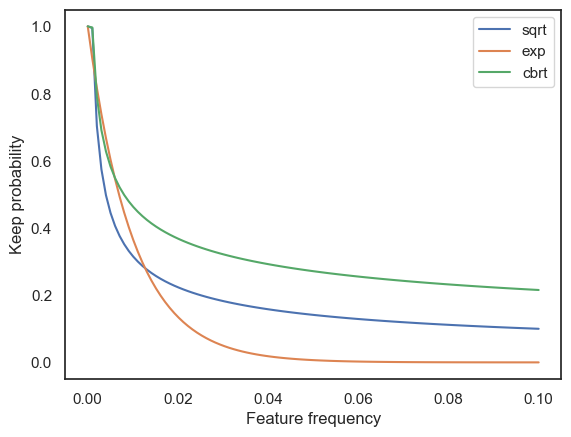

In [5]:
t = 1e-3
p = np.linspace(0, 0.1, 100)
keep_probability1 = np.minimum(1.0, np.sqrt(t / np.maximum(p, 1e-12)))
keep_probability2 = np.minimum(1.0, np.exp( np.maximum(p, 1e-12) / -t * 1e-1 ))
keep_probability3 = np.minimum(1.0, np.cbrt(t / np.maximum(p, 1e-12)))

plt.plot(p, keep_probability1, label=f"sqrt")
plt.plot(p, keep_probability2, label="exp")
plt.plot(p, keep_probability3, label="cbrt")
plt.legend()
plt.xlabel("Feature frequency")
plt.ylabel("Keep probability")

In [6]:
# Negative sampling distribution
frequency = adata.var.cisTopic_nr_acc / adata.var.cisTopic_nr_acc.sum()
neg_probability = np.power(np.maximum(frequency, 1e-12), 0.75)
neg_probability = neg_probability / neg_probability.sum()

# Subsampling distribution
t = 5e-7
keep_probability = np.minimum(1.0, np.sqrt(t / np.maximum(frequency, 1e-12)))

# Add those to adata.var
adata.var["neg"] = neg_probability
adata.var["keep"] = keep_probability
adata.var["frequency"] = frequency

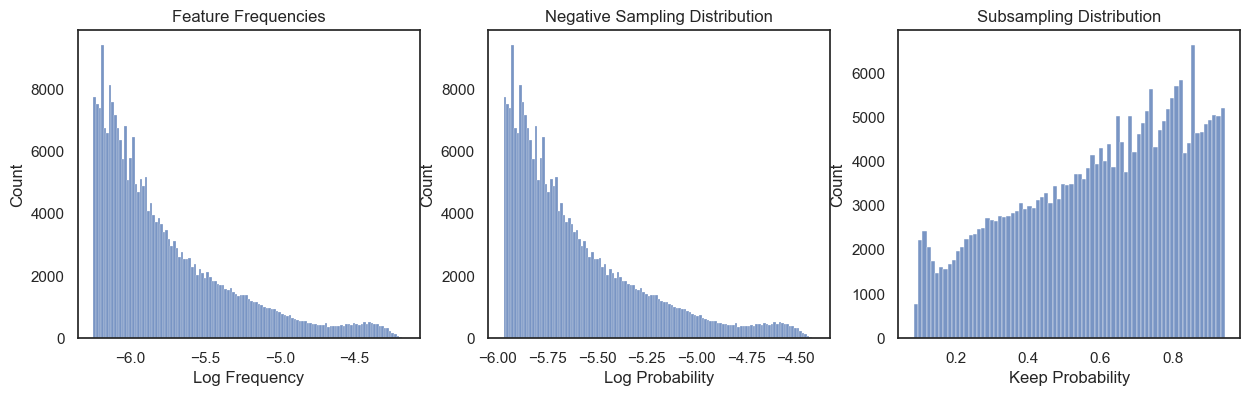

In [7]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

sns.histplot(np.log10(frequency), ax=ax1)
ax1.set_xlabel("Log Frequency")
ax1.set_title("Feature Frequencies")

sns.histplot(np.log10(neg_probability), ax=ax2)
ax2.set_xlabel("Log Probability")
ax2.set_title("Negative Sampling Distribution")

sns.histplot(keep_probability, ax=ax3)
ax3.set_xlabel("Keep Probability")
ax3.set_title("Subsampling Distribution")
plt.show()

<Axes: xlabel='neg', ylabel='Chromosome'>

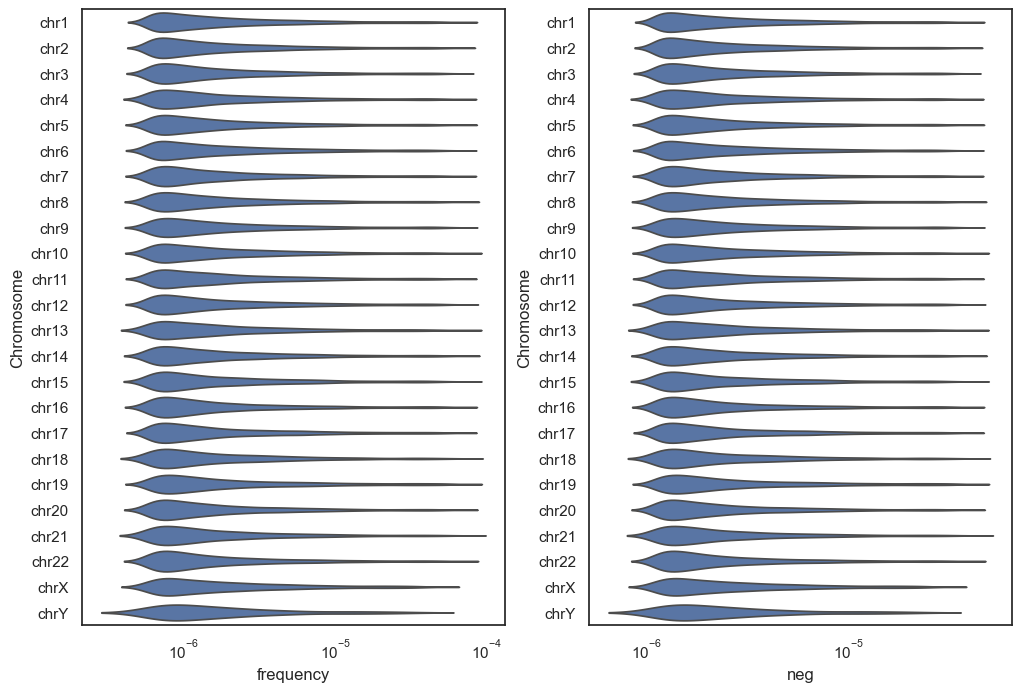

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
sns.violinplot(data=adata.var, x="frequency", y="Chromosome", log_scale=10, ax=ax1, inner=None)
sns.violinplot(data=adata.var, x="neg", y="Chromosome", log_scale=10, ax=ax2, inner=None)

<Axes: xlabel='proportion', ylabel='Chromosome'>

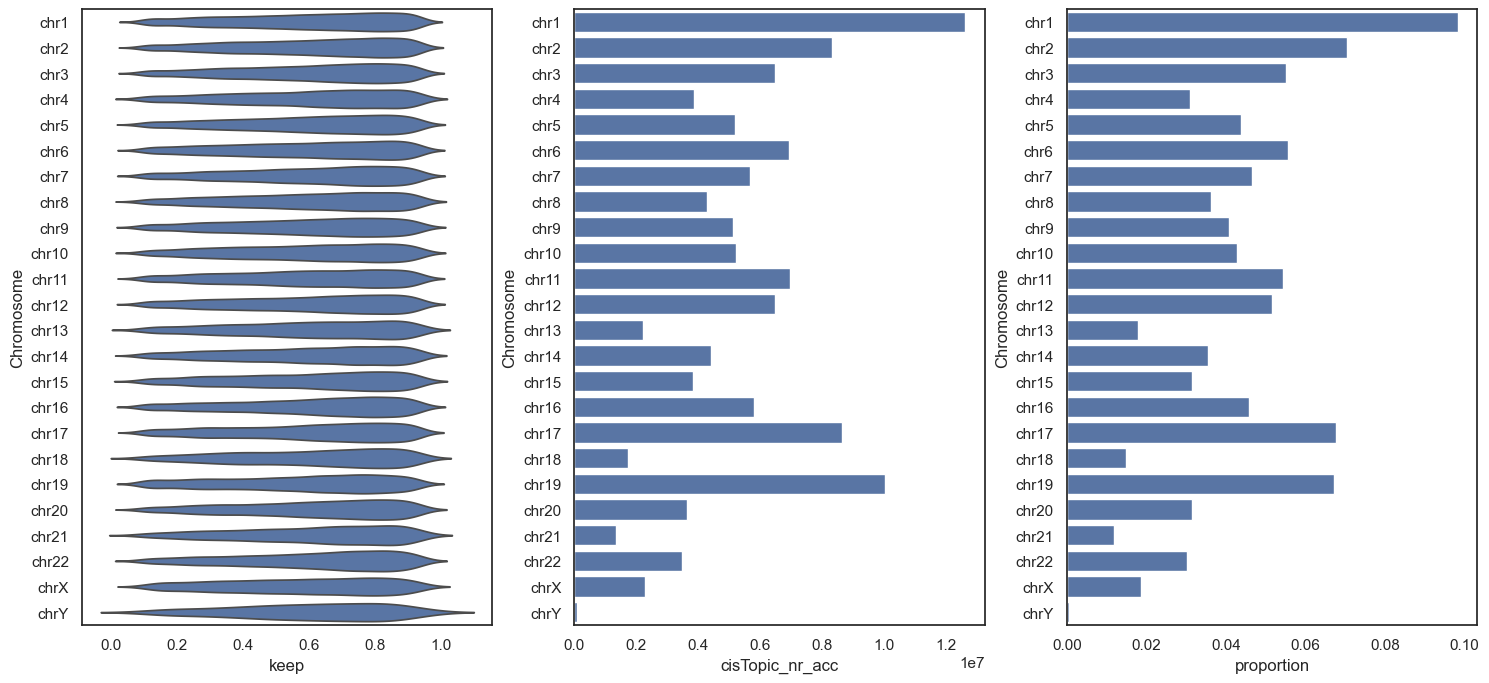

In [9]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 8))


sns.violinplot(data=adata.var, x="keep", y="Chromosome", ax=ax1, inner=None)
sns.barplot(data=adata.var, x="cisTopic_nr_acc", y="Chromosome", errorbar=None, estimator="sum", ax=ax2)
sns.countplot(data=adata.var, y="Chromosome", stat="proportion", ax=ax3)

## Dataset



In [10]:
import torch.nn as nn
from torch.utils.data import IterableDataset, DataLoader, get_worker_info
from collections import defaultdict

In [32]:
class PeakDataset(IterableDataset):
    def __init__(self, adata, samples_per_epoch=10000, n_pairs=10, n_negative=20, seed=4, trans_fraction=0.2, cis_window=500000, same_chr_negative_prob=0.5):
        self.adata = adata
        self.samples_per_epoch = samples_per_epoch
        self.n_pairs = n_pairs
        self.n_negative = n_negative
        self.seed = seed
        self.trans_fraction = trans_fraction
        self.cis_window = cis_window
        self.same_chr_negative_prob = same_chr_negative_prob

        self.X = adata.X
        self.n_cells, self.n_peaks = self.X.shape
        self.chr = adata.var["Chromosome"].values
        self.start = adata.var["Start"].values
        self.end = adata.var["End"].values

        # Negative sampling distribution
        self.neg_distribution = torch.from_numpy(adata.var["neg"].values)
        self.neg_cat_all = torch.distributions.categorical.Categorical(probs=self.neg_distribution)

        self.by_chr = {}
        self.neg_cat_chr = {}
        for u in np.unique(self.chr):
            idxs = np.where(self.chr == u)[0]
            self.by_chr[u] = idxs
            f = (adata.var.cisTopic_nr_acc.values[idxs].astype(np.float64) ** 0.75)
            self.neg_cat_chr[u] = torch.distributions.categorical.Categorical(
                probs=torch.from_numpy(f / (f.sum() + 1e-12)).float()
            )

        # Subsampling distribution
        self.keep_distribution = adata.var["keep"].values

        # Counter
        self.counter = defaultdict(int)

    def _open_cell_peaks(self, cell_idx, rng):
        start, end = self.X.indptr[cell_idx], self.X.indptr[cell_idx + 1]
        peaks = self.X.indices[start:end]
        if peaks.size < 2:
            return peaks
        #print(cell_idx)
        #print(self.chr[peaks].value_counts())
        mask = rng.random(peaks.size) < self.keep_distribution[peaks]
        peaks = peaks[mask] if mask.any() else peaks
        return peaks
    
    def _sample_pair(self, peak_idx, open_peaks, rng):
        chr = self.chr[peak_idx]
        c_mid = (self.start[peak_idx] + self.end[peak_idx]) // 2

        if rng.random() > self.trans_fraction:
            candidates = open_peaks[(self.chr[open_peaks] == chr) & (open_peaks != peak_idx)]
            if candidates.size > 0:
                mids = (self.start[candidates] + self.end[candidates]) // 2
                distances = np.abs(mids - c_mid)
                in_cis_window = distances <= self.cis_window
                if in_cis_window.any():
                    weights = np.exp(-distances[in_cis_window] / self.cis_window)
                    weights = weights / (weights.sum() + 1e-12)
                    return int(rng.choice(candidates[in_cis_window], p=weights))


        paired_peaks = open_peaks[open_peaks != peak_idx]
        return int(rng.choice(paired_peaks)) if paired_peaks.size > 0 else None
    
    def _sample_negatives(self, peak_idx, pair_idx, rng):
        if rng.random() < self.same_chr_negative_prob:
            chr = self.chr[peak_idx]
            idxs = self.by_chr[chr]
            draws = self.neg_cat_chr[chr].sample((self.n_negative,))
            negatives = torch.from_numpy(idxs[draws.numpy().astype(int)])
        else:
            negatives = self.neg_cat_all.sample((self.n_negative,))

        if isinstance(negatives, torch.Tensor):
            negatives = torch.where(negatives == peak_idx, (negatives + 1) % self.n_peaks, negatives)
            negatives = torch.where(negatives == pair_idx, (negatives + 2) % self.n_peaks, negatives)
        return negatives

    def __iter__(self):
        wi = get_worker_info()
        worker_id = wi.id if wi else 0
        rng = np.random.Generator(np.random.PCG64(self.seed + 1337 * (worker_id + 1)))

        produced = 0
        while produced < self.samples_per_epoch:
            cell_idx = rng.integers(0, self.n_cells)
            open_peaks = self._open_cell_peaks(cell_idx, rng)
            if open_peaks.size < 2:
                continue

            sampled_peaks = rng.choice(open_peaks, size=self.n_pairs, replace=(len(open_peaks) < self.n_pairs))
            #print(self.chr[sampled_peaks].to_list())
            for peak_idx in sampled_peaks:
                #print(self.chr[peak_idx])
                pair_idx = self._sample_pair(peak_idx, open_peaks, rng)
                if pair_idx is None:
                    continue

                negatives = self._sample_negatives(peak_idx, pair_idx, rng)
                #self.counter[self.chr[peak_idx]] += 1
                yield int(peak_idx), int(pair_idx), negatives

                produced += 1
                if produced >= self.samples_per_epoch:
                    break

## DataLoader

In [12]:
rng = np.random.Generator(np.random.PCG64(4))
rng.integers(0, adata.n_obs)

np.int64(7355)

In [13]:
def peak2vec_collate(batch):
    peaks, peak_pairs, negatives = zip(*batch)
    peaks = torch.tensor(peaks, dtype=torch.long)
    peak_pairs = torch.tensor(peak_pairs, dtype=torch.long)
    negatives = torch.stack(negatives, dim=0).long()
    return peaks, peak_pairs, negatives

In [14]:
dataset = PeakDataset(adata, samples_per_epoch=1000, n_pairs=8, n_negative=15, seed=4, trans_fraction=0.2, cis_window=500000, same_chr_negative_prob=0.5)
loader = DataLoader(dataset, batch_size=16, collate_fn=peak2vec_collate, num_workers=0, pin_memory=True)

In [15]:
iterator = iter(loader)

In [16]:
peaks, peak_pairs, negatives = next(iterator)
peaks.size(), peak_pairs.size(), negatives.size(), dataset.counter, peaks, peak_pairs

(torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 15]),
 defaultdict(int, {}),
 tensor([ 61234, 212182, 166011, 242962, 161763, 129261, 248577, 129744,  69199,
         166949, 253743, 129277, 236153, 192671,  90204, 253753]),
 tensor([119721, 237351, 164382, 248407, 157050,  84051, 123787, 130413,  83581,
         140723, 190014,  97194, 219615, 118363, 251010, 249586]))

In [17]:
cell_idx = 4725
start, end = adata.layers["counts"].indptr[cell_idx], adata.layers["counts"].indptr[cell_idx + 1]
peaks = adata.X.indices[start:end]

In [18]:
adata.layers["counts"]

<Compressed Sparse Column sparse matrix of dtype 'int32'
	with 112350377 stored elements and shape (10126, 264916)>

In [19]:
start, end = adata.layers["counts"].indptr[cell_idx], adata.layers["counts"].indptr[cell_idx + 1]
peaks = adata.layers["counts"].indices[start:end]
peaks.size

155

In [20]:
adata.X

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 112350377 stored elements and shape (10126, 264916)>

In [21]:
start, end = adata.X.indptr[cell_idx], adata.X.indptr[cell_idx + 1]
peaks = adata.X.indices[start:end]
peaks.size

11321

In [22]:
print("adata.X:", type(adata.X), adata.X.nnz)
print("counts layer:", type(adata.layers["counts"]), adata.layers["counts"].nnz)

adata.X: <class 'scipy.sparse._csr.csr_matrix'> 112350377
counts layer: <class 'scipy.sparse._csc.csc_matrix'> 112350377


In [23]:
print("adata.X:", type(adata.X), adata.X.nnz)
print("counts layer:", type(adata.layers["counts"]), adata.layers["counts"].nnz)
print("binary layer:", type(adata.layers["binary"]), adata.layers["binary"].nnz)
print("Same sparsity pattern (X vs counts):", (adata.X != 0).nnz == (adata.layers["counts"] != 0).nnz)
print("Same sparsity pattern (X vs binary):", (adata.X != 0).nnz == (adata.layers["binary"] != 0).nnz)

adata.X: <class 'scipy.sparse._csr.csr_matrix'> 112350377
counts layer: <class 'scipy.sparse._csc.csc_matrix'> 112350377
binary layer: <class 'scipy.sparse._csc.csc_matrix'> 112350377
Same sparsity pattern (X vs counts): True
Same sparsity pattern (X vs binary): True


In [24]:
adata.obs.iloc[155]

cisTopic_nr_frag                                              11661
cisTopic_log_nr_frag                                       4.066736
cisTopic_nr_acc                                                9202
cisTopic_log_nr_acc                                        3.963882
sample_id                                                   pbmc10k
barcode_rank                                                   8167
total_fragments_count                                         21376
log10_total_fragments_count                                4.329947
unique_fragments_count                                        14116
log10_unique_fragments_count                               4.149742
total_fragments_in_peaks_count                                17033
log10_total_fragments_in_peaks_count                       4.231317
unique_fragments_in_peaks_count                               11085
log10_unique_fragments_in_peaks_count                      4.044775
fraction_of_fragments_in_peaks                  

In [25]:
peaks.size

11321

In [26]:
adata.layers["binary"]

<Compressed Sparse Column sparse matrix of dtype 'int32'
	with 112350377 stored elements and shape (10126, 264916)>

In [27]:
peaks, peak_pairs, negatives = next(iterator)
peaks.size(), peak_pairs.size(), negatives.size(), dataset.counter, peaks, peak_pairs

(torch.Size([16]),
 torch.Size([16]),
 torch.Size([16, 15]),
 defaultdict(int, {}),
 tensor([  9145,  99409, 180566, 178488, 124457, 133594,  86483,  49775, 173417,
         229954, 166094, 182873, 159244, 151529, 260520, 228617]),
 tensor([  7813, 100574, 182255,  84735, 118752, 128712, 216765,  52545, 175092,
         229924, 170059, 128626, 159212, 148046, 262242, 227719]))

## Model

In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Peak2Vec(nn.Module):
    def __init__(self, n_peaks, embedding_dim=64):
        super(Peak2Vec, self).__init__()
        self.dim = embedding_dim
        self.embedding = nn.Embedding(n_peaks, embedding_dim)
        
        self.reset_params()
    
    def reset_params(self):
        nn.init.uniform_(self.embedding.weight, -0.5 / self.dim, 0.5 / self.dim)

    def forward(self, peaks, peak_pairs, negatives):
        # Embeddings
        peak_emb = self.embedding(peaks)               # (B, D)
        pair_emb = self.embedding(peak_pairs)          # (B, D)
        neg_emb = self.embedding(negatives)            # (B, K, D)

        # Compute similarity scores
        pos_score = torch.sum(peak_emb * pair_emb, dim=1)                   # (B)
        neg_score = torch.bmm(neg_emb, peak_emb.unsqueeze(2)).squeeze(2)    # (B, K)

        # Loss
        poss_loss = F.softplus(-pos_score)         # -log(sigmoid(x)) = softplus(-x)
        neg_loss = F.softplus(neg_score).sum(1)      # -log(1 - sigmoid(x)) = softplus(x)
        loss = (poss_loss + neg_loss).mean()

        with torch.no_grad():
            stats = {
                "pos_score_mean": pos_score.mean().detach(),
                "neg_score_mean": neg_score.mean().detach(),
                "pos_loss_mean":  poss_loss.mean().detach(),
                "neg_loss_mean":  neg_loss.mean().detach(),
            }
        return loss, stats
    
    @torch.no_grad()
    def get_peak_embeddings(self, normalize=True):
        embeddings = self.embedding.weight.detach().cpu()
        if normalize:
            embeddings = F.normalize(embeddings, p=2, dim=1)
        return embeddings
    
    @torch.no_grad()
    def most_similar(self, peak_idx, topk=10):
        embeddings = self.get_peak_embeddings(normalize=True)  # (N, D)
        peak_emb = embeddings[peak_idx:peak_idx+1]          # (1, D)
        similarities = (embeddings @ peak_emb.t()).squeeze(1)  # (N)
        values, indices = torch.topk(similarities, topk + 1, embeddings.size(0), largest=True)
        # drop self if in topk
        if indices and indices[0] == peak_idx:
            indices, values = indices[1:], values[1:]
        return indices[:topk], values[:topk]


## Training

In [35]:
seed = 4
n_pairs = 20
n_negative = 10
samples_per_epoch = 20000
batch_size = 512
embedding_dim = 128
trans_fraction=0.2
cis_window=500000
same_chr_negative_prob=0.5
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

dataset = PeakDataset(adata, samples_per_epoch=samples_per_epoch, n_pairs=n_pairs, n_negative=n_negative, seed=seed, trans_fraction=trans_fraction, cis_window=cis_window, same_chr_negative_prob=same_chr_negative_prob)
loader = DataLoader(dataset, batch_size=batch_size, collate_fn=peak2vec_collate, num_workers=0, pin_memory=True)
model = Peak2Vec(adata.n_vars, embedding_dim=embedding_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)

Using device: cuda


In [36]:
num_epochs = 100

history = list()
for epoch in range(1, num_epochs + 1):
    model.train()

    running = 0.0
    running_pos = 0.0
    running_neg = 0.0
    for step, (peaks, peak_pairs, negatives) in enumerate(loader, 1):
        peaks = peaks.to(device, non_blocking=True)
        peak_pairs = peak_pairs.to(device, non_blocking=True)
        negatives = negatives.to(device, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)
        loss, stats = model(peaks, peak_pairs, negatives)
        loss.backward()
        
        optimizer.step()

        running += float(loss.detach().cpu())
        running_pos += float(stats["pos_loss_mean"].cpu())
        running_neg += float(stats["neg_loss_mean"].cpu())

        #print(f"Epoch {epoch} | Step {step:03d} | Loss: {running / step:.4f} | Pos Loss: {stats['pos_loss_mean']:.4f} | Neg Loss: {stats['neg_loss_mean']:.4f} | Pos Score: {stats['pos_score_mean']:.4f} | Neg Score: {stats['neg_score_mean']:.4f}")
    
    # Log epoch stats
    stats["running_loss"] = running / step
    stats["pos_loss_mean"] = running_pos / step
    stats["neg_loss_mean"] = running_neg / step
    history.append(stats)
    print(f"Epoch {epoch} | Step {step:03d} | Loss: {running / step:.4f} | Pos Loss: {stats['pos_loss_mean']:.4f} | Neg Loss: {stats['neg_loss_mean']:.4f} | Pos Score: {stats['pos_score_mean']:.4f} | Neg Score: {stats['neg_score_mean']:.4f}")

Epoch 1 | Step 040 | Loss: 7.6246 | Pos Loss: 0.6931 | Neg Loss: 6.9315 | Pos Score: -0.0000 | Neg Score: 0.0001
Epoch 2 | Step 040 | Loss: 7.6207 | Pos Loss: 0.6893 | Neg Loss: 6.9314 | Pos Score: 0.0143 | Neg Score: -0.0001
Epoch 3 | Step 040 | Loss: 7.6068 | Pos Loss: 0.6756 | Neg Loss: 6.9311 | Pos Score: 0.0551 | Neg Score: 0.0003
Epoch 4 | Step 040 | Loss: 7.5824 | Pos Loss: 0.6522 | Neg Loss: 6.9302 | Pos Score: 0.1187 | Neg Score: -0.0013
Epoch 5 | Step 040 | Loss: 7.5463 | Pos Loss: 0.6183 | Neg Loss: 6.9280 | Pos Score: 0.2164 | Neg Score: -0.0011
Epoch 6 | Step 040 | Loss: 7.4990 | Pos Loss: 0.5754 | Neg Loss: 6.9237 | Pos Score: 0.3425 | Neg Score: -0.0027
Epoch 7 | Step 040 | Loss: 7.4425 | Pos Loss: 0.5258 | Neg Loss: 6.9168 | Pos Score: 0.5029 | Neg Score: -0.0037
Epoch 8 | Step 040 | Loss: 7.3753 | Pos Loss: 0.4732 | Neg Loss: 6.9021 | Pos Score: 0.6875 | Neg Score: -0.0100
Epoch 9 | Step 040 | Loss: 7.3015 | Pos Loss: 0.4208 | Neg Loss: 6.8807 | Pos Score: 0.8937 | Neg

Text(0.5, 1.0, 'Negative Score')

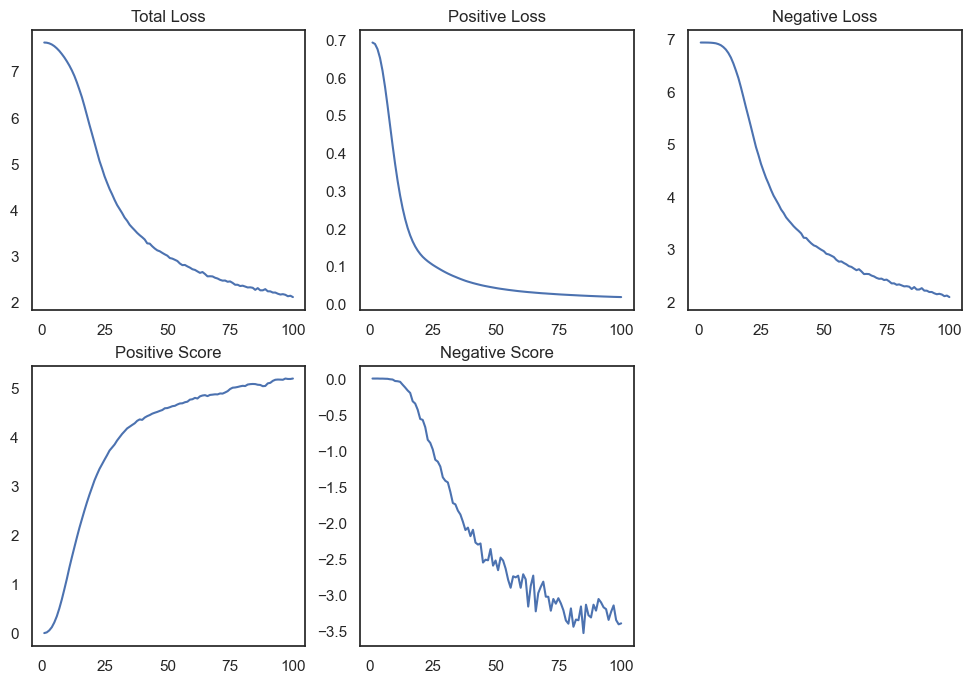

In [37]:
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(12, 8))

loss = [h["running_loss"] for h in history]
pos_loss = [h["pos_loss_mean"] for h in history]
neg_loss = [h["neg_loss_mean"] for h in history]
poss_score = [h["pos_score_mean"].detach().cpu() for h in history]
neg_score = [h["neg_score_mean"].detach().cpu() for h in history]

ax1.plot(range(1, num_epochs + 1), loss, label="Total Loss")
ax2.plot(range(1, num_epochs + 1), pos_loss, label="Positive Loss")
ax3.plot(range(1, num_epochs + 1), neg_loss, label="Negative Loss")
ax4.plot(range(1, num_epochs + 1), poss_score, label="Positive Score")
ax5.plot(range(1, num_epochs + 1), neg_score, label="Negative Score")
ax6.axis("off")

ax1.set_title("Total Loss")
ax2.set_title("Positive Loss")
ax3.set_title("Negative Loss")
ax4.set_title("Positive Score")
ax5.set_title("Negative Score")

In [38]:
emb = model.get_peak_embeddings(normalize=False).numpy()
np.save(f"data/peak2vec_epoch_{embedding_dim}.npy", emb)

emb = model.get_peak_embeddings(normalize=True).numpy()
np.save(f"data/peak2vec_epoch_norm_{embedding_dim}.npy", emb)

In [39]:
torch.save(model, 'data/peak2vec_model.pth')

## Visualize

### Peaks

In [40]:
# adata_peaks = adata.transpose().copy()
adata_peaks.obsm["peak2vec"] = emb
adata_peaks

AnnData object with n_obs × n_vars = 264916 × 10126
    obs: 'Chromosome', 'Start', 'End', 'Width', 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'n_cells_per_feature', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'leiden'
    var: 'cisTopic_nr_frag', 'cisTopic_log_nr_frag', 'cisTopic_nr_acc', 'cisTopic_log_nr_acc', 'sample_id', 'barcode_rank', 'total_fragments_count', 'log10_total_fragments_count', 'unique_fragments_count', 'log10_unique_fragments_count', 'total_fragments_in_peaks_count', 'log10_total_fragments_in_peaks_count', 'unique_fragments_in_peaks_count', 'log10_unique_fragments_in_peaks_count', 'fraction_of_fragments_in_peaks', 'duplication_count', 'duplication_ratio', 'nucleosome_signal', 'tss_enrichment', 'pdf_values_for_tss_enrichment', 'pdf_values_for_fraction_of_fragments_in_peaks', 'pdf_values_for_duplication_ratio', 'barcode', 'n_features_per_cell', 'total_fragment_counts', 'leiden'
    uns: 'Chromosome_colors', 'leiden

In [41]:
# Find neighbors
sc.pp.neighbors(adata_peaks, use_rep="peak2vec", n_neighbors=15, n_pcs=50, metric="cosine")

# Calculate clusters
# sc.tl.leiden(adata_peaks, flavor="igraph", n_iterations=2)

# Calculate UMAP
sc.tl.umap(adata_peaks, random_state=4)

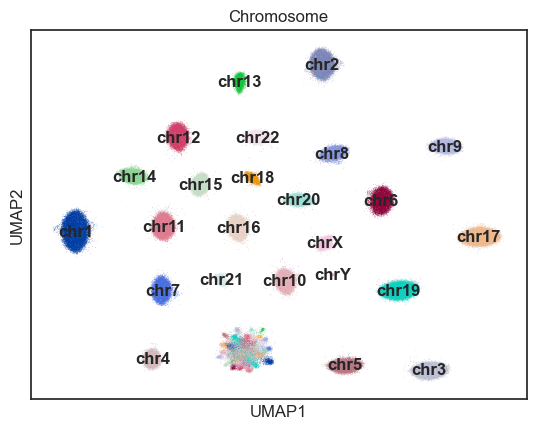

In [46]:
sc.pl.umap(adata_peaks, color=["Chromosome"], ncols=1, legend_loc="on data")

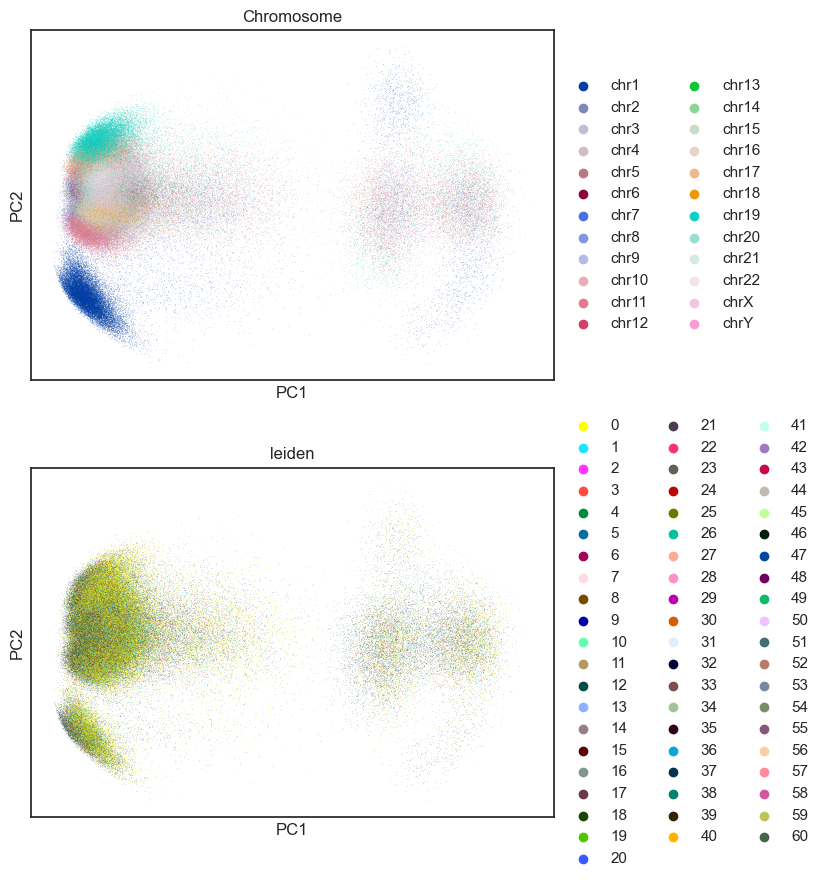

In [43]:
adata_peaks.obsm["X_pca"] = sc.pp.pca(emb, n_comps=50)
sc.pl.pca(adata_peaks, color=["Chromosome", "leiden"], ncols=1)

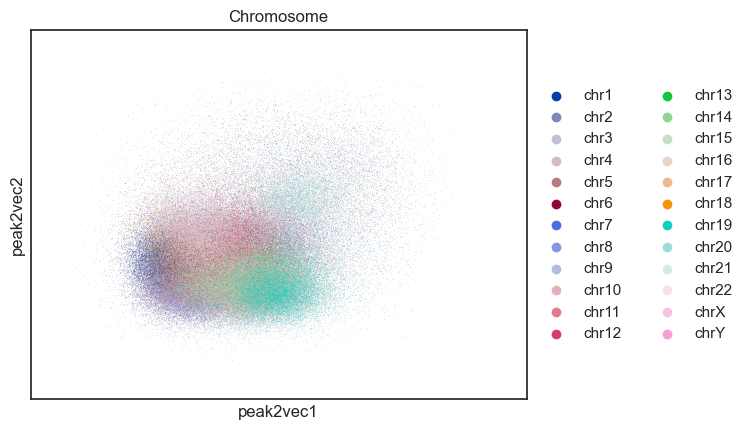

In [44]:
sc.pl.embedding(adata_peaks, basis="peak2vec", color=["Chromosome"])

### Cells

In [47]:
adata.obsm["peak2vec"] = adata.X @ emb
# Find neighbors
sc.pp.neighbors(adata, use_rep="peak2vec", n_neighbors=15, n_pcs=30)

# Calculate UMAP
sc.tl.umap(adata, random_state=4)

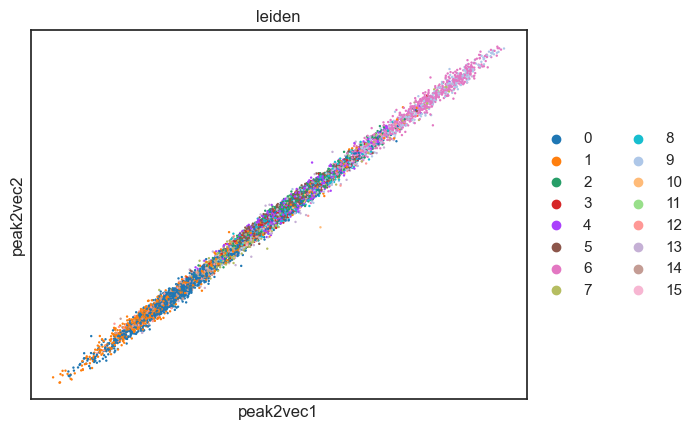

In [49]:
sc.pl.embedding(adata, basis="peak2vec", color=["leiden"])

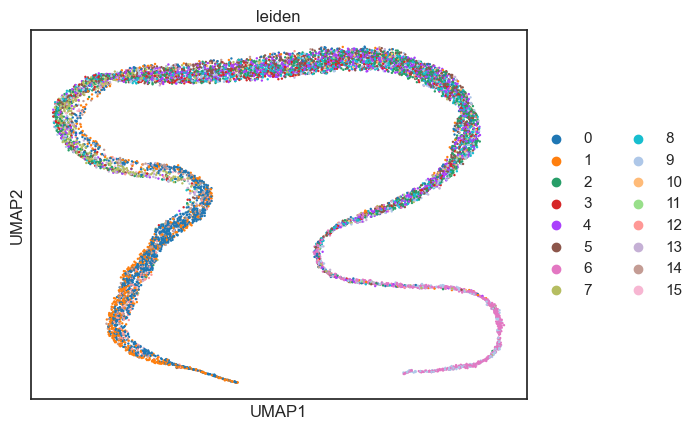

In [50]:
sc.pl.umap(adata, color=["leiden"])